In [ ]:
#最初にマウント→メールアドレス選択→許可→「Mounted at /content/drive」を確認
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-3-8d46d9ec743e>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_org = pd.read_csv('/content/drive/My Drive/tokyo_hausing_train.csv')
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CV r2: [0.84678718 0.81296364 0.83340073 0.81600697 0.79961559 0.81199692
 0.83900341 0.82484535 0.83843965 0.82318162]
CV r2: 0.825 +/- 0.014


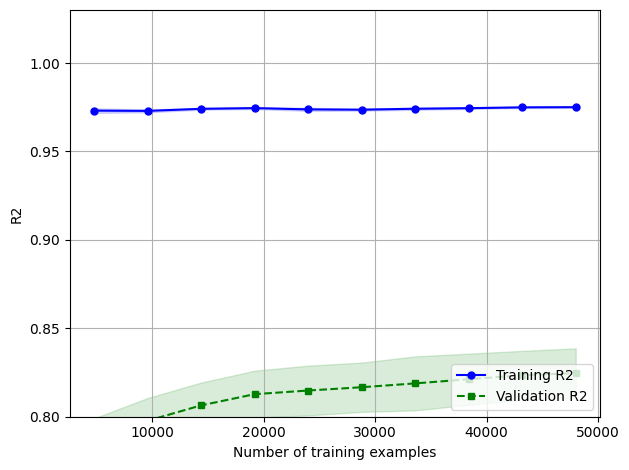

0.9751205579538458
0.8268487411519462


In [ ]:
# 訓練データの読み込み
import csv
import pandas as pd
df_train_org = pd.read_csv('/content/drive/My Drive/tokyo_hausing_train.csv')

# 特徴量（絞り込み済）＋目的変数
df_train_X_y = df_train_org.iloc[:,[3,8,9,10,14,24,27]]

# 1項目でもNaNがある行は削除する
df_train_X_y_drna = df_train_X_y.dropna(axis=0)

# 「'H'､'分'､'㎡'を含む項目」を含む行を削除する
df_train_X_y_drna.columns = ['post','minute','mad','area','born','bai','price']
df_train_X_y_drna = df_train_X_y_drna[df_train_X_y_drna['minute'].str.contains('H') == False]
df_train_X_y_drna = df_train_X_y_drna[df_train_X_y_drna['minute'].str.contains('分') == False]
df_train_X_y_drna = df_train_X_y_drna[df_train_X_y_drna['area'].str.contains('㎡') == False]

# 確認用
#df_train_X_y_drna.isnull().sum(axis=0)
#df_train_X_y_drna

# 改めて学習データをＸ（特徴量）とｙ（目的変数）へ分割
df_train_X = df_train_X_y_drna.iloc[:,:6]
df_train_y = df_train_X_y_drna.iloc[:,6]

# 学習データへ見出し付け、カテゴリ変数列を指定し、ラベルエンコーディングを実施
df_train_X.columns = ['postno','minute','madori','area','born','baibai']

from sklearn.preprocessing import LabelEncoder

cat_cols = ['postno','madori','born','baibai']
for c in cat_cols:
  le = LabelEncoder()
  df_train_X[c] = le.fit_transform(df_train_X[c])

# 学習データを、訓練データと検証データへ分割する
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    df_train_X, df_train_y, test_size=0.1, random_state=0
    )

# 機械学習アルゴリズムにランダムフォレスト回帰を使用
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=0, n_jobs=-1)

# 評価指標として決定係数（R^2）を使う
import numpy as np
from sklearn.metrics import r2_score

# 訓練データに対し、層化10分割交差検証を実施する
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=forest,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         scoring='r2',
                         n_jobs=-1)

# 10個の決定係数を求め、平均と標準偏差を計算する
print(f'CV r2: {scores}')
print(f'CV r2: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

# 学習曲線を描く
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=forest,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               scoring='r2',
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training R2')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation R2')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('R2')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('figures/06_05.png', dpi=300)
plt.show()

# 改めて学習データ全体（訓練データ＋検証データ）でランダムフォレスト回帰を適合
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_valid_pred = forest.predict(X_valid)

# 訓練データ、検証データそれぞれの精度を決定係数（R^2）で評価し、表示する
train_r2 = r2_score(y_train,y_train_pred)
valid_r2 = r2_score(y_valid,y_valid_pred)

print(train_r2)
print(valid_r2)
